In [20]:
import sys; sys.path.append('..')
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from src.utils.metrics import (
    compute_average_accuracy,
    compute_forgetting_measure,
    compute_learning_curve_area,
    compute_ausuc,
    compute_ausuc_matrix,
    compute_individual_accs_matrix,
    compute_task_transfer_matrix,
    compute_seen_classes_acc_history,
    compute_unseen_classes_acc_history,
    compute_joined_ausuc_history,
    compute_acc_for_classes
)


def compute_average_taskwise_accucy(logits_history, targets, class_splits):
    assert len(logits_history) == len(class_splits) + 1
    
    acc_matrix = compute_individual_accs_matrix(logits_history[1:], targets, class_splits)
    acc_matrix = np.tril(acc_matrix)
    accs = acc_matrix.sum(axis=1) / np.arange(1, len(class_splits) + 1)
    
    return accs

In [38]:
import collections
from typing import Dict, List

from firelab.config import Config
import pandas as pd
from tqdm import tqdm

def get_exp_args(config: Config):
    short_name_to_name = {
        #'protos': 'hp.head.num_prototypes',
        'after_fuse_transform_layers': 'hp.head.after_fuse_transform_layers',
    }
    
    return {short_name: config.get(name) for short_name, name in short_name_to_name.items()}


def get_exp_shortname(config: Config):
    return ' '.join([f'[{k}: {v}]' for k, v in get_exp_args(config).items()])


def find_exps(experiments_dir: os.PathLike) -> Dict[str, List[str]]:
    """
    Returns dictionary, where a key is a shortname of the experiment
    and the value is the list of different runs (grouped by shortname)
    """
    experiments_dirs = [os.path.join(experiments_dir, e) for e in os.listdir(experiments_dir)]
    configs = [Config.load(os.path.join(e, 'config.yml')) for e in tqdm(experiments_dirs, desc='Loading configs')]
    shortnames = [get_exp_shortname(c) for c in configs]
    
    result = collections.defaultdict(list)
    for e, name in zip(experiments_dirs, shortnames):
        result[name].append(e)

    return dict(result)

In [39]:
dataset = 'CUB'
tasks = np.arange(1, 11)
# experiments_dir = '/ibex/scratch/skoroki/experiments/generative_training'
# experiments_dir = '/ibex/scratch/skoroki/experiments/autoencoding_loss'
# experiments_dir = '/ibex/scratch/skoroki/experiments/dropout'
experiments_dir = '../overfitting'

exps = find_exps(experiments_dir)
exps = {m: [e for e in exps[m] if os.path.exists(f'{e}/custom_data/logits_history.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{e}/custom_data/targets.npy')] for m in exps}
exps = {m: [e for e in exps[m] if os.path.exists(f'{e}/custom_data/class_splits.npy')] for m in exps}
exps = {m: exps[m] for m in exps if len(exps[m]) > 0}
methods = list(exps.keys())

logits_histories = {m: [np.load(f'{e}/custom_data/logits_history.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading logits histories')}
train_logits_histories = {m: [np.load(f'{e}/custom_data/train_logits_history.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading logits histories')}
targets = {m: [np.load(f'{e}/custom_data/targets.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading targets')}
train_targets = {m: [np.load(f'{e}/custom_data/train_targets.npy') for e in exps[m]] for m in tqdm(exps, desc='Loading targets')}
class_splits = {m: [np.load(f'{e}/custom_data/class_splits.npy', allow_pickle=True) for e in exps[m]] for m in tqdm(exps, desc='Loading class splits')}
configs = {m: [Config.load(f'{e}/config.yml') for e in exps[m]] for m in tqdm(exps, desc='Loading configs')}

Loading configs: 100%|██████████| 4/4 [00:00<00:00, 62.54it/s]


In [44]:
from src.utils.data_utils import construct_output_mask

def plot_unseen_acc(methods, restrict_space: bool=False, title: str=''):
    plt.figure(figsize=(15, 7))
    plt.title(f'[{title}]: accuracy on unseen for {dataset} (space restriction: {restrict_space})')

    for method in methods:
        values = [compute_unseen_classes_acc_history(l[:-1], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
        values_avg = np.array(values).mean(0) * 100
        
        values_train = [compute_unseen_classes_acc_history(l[:-1], t, c, restrict_space=restrict_space) for l, t, c in zip(train_logits_histories[method], train_targets[method], class_splits[method])]
        values_avg_train = np.array(values_train).mean(0) * 100
        
        #kwargs = {'lineStyle': '--'} if 'true' in method else {}
        kwargs = {}
        plt.plot(tasks, values_avg, label=f'[TEST] {method} (final: {values_avg[-1]: .3f})', **kwargs)
        plt.plot(tasks, values_avg_train, label=f'[TRAIN] {method} (final: {values_avg_train[-1]: .3f})', **{'lineStyle': '--'})

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
    # plt.legend()
    plt.xlabel('Task')
    plt.ylabel('Accuracy on unseen classes')
    plt.xticks(tasks)
    plt.grid()


def plot_seen_acc(methods, restrict_space: bool=False, title: str=''):
    plt.figure(figsize=(15, 7))
    plt.title(f'[{title}]: accuracy on seen for {dataset} (space restriction: {restrict_space})')

    for method in methods:
        values = [compute_seen_classes_acc_history(l[1:], t, c, restrict_space=restrict_space) for l, t, c in zip(logits_histories[method], targets[method], class_splits[method])]
        values_avg = np.array(values).mean(0) * 100
        
        values_train = [compute_seen_classes_acc_history(l[1:], t, c, restrict_space=restrict_space) for l, t, c in zip(train_logits_histories[method], train_targets[method], class_splits[method])]
        values_avg_train = np.array(values_train).mean(0) * 100
        
        #kwargs = {'lineStyle': '--'} if 'true' in method else {}
        kwargs = {}
        plt.plot(tasks, values_avg, label=f'[TEST] {method} (final: {values_avg[-1]: .3f})', **kwargs)
        plt.plot(tasks, values_avg_train, label=f'[TRAIN] {method} (final: {values_avg_train[-1]: .3f})', **{'lineStyle': '--'})

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
    #plt.legend()
    plt.xlabel('Task')
    plt.ylabel('Accuracy on seen classes')
    plt.xticks(tasks)
    plt.grid()
    

    
def get_exps_for_a_group(exps, configs, group):
    result = {}
    
    for exp_shortname, exp_paths in exps.items():
        config = configs[exp_shortname][0]
        
        if all(config.get(k) == v for k, v in group.items()):
            result[exp_shortname] = exp_paths
    
    result = {k: result[k] for k in sorted(result.keys())}
    
    return result

100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


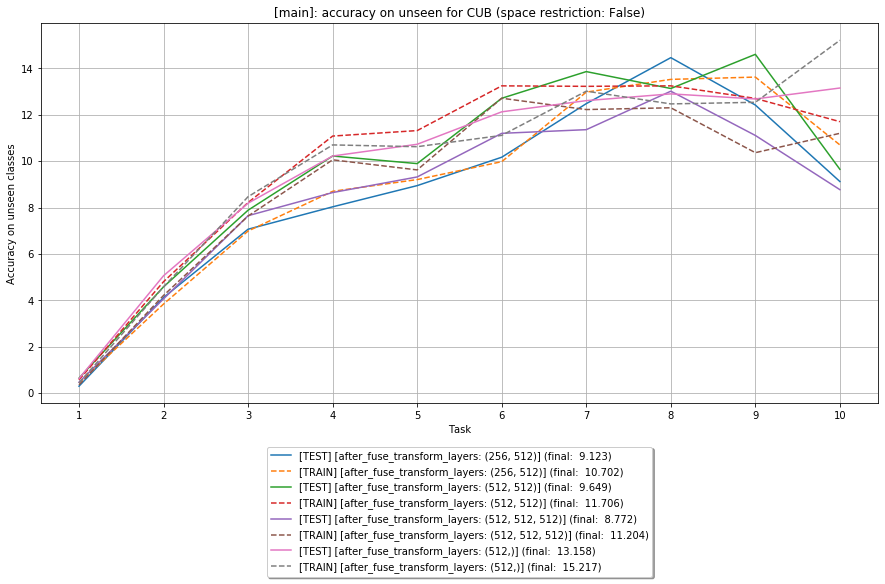

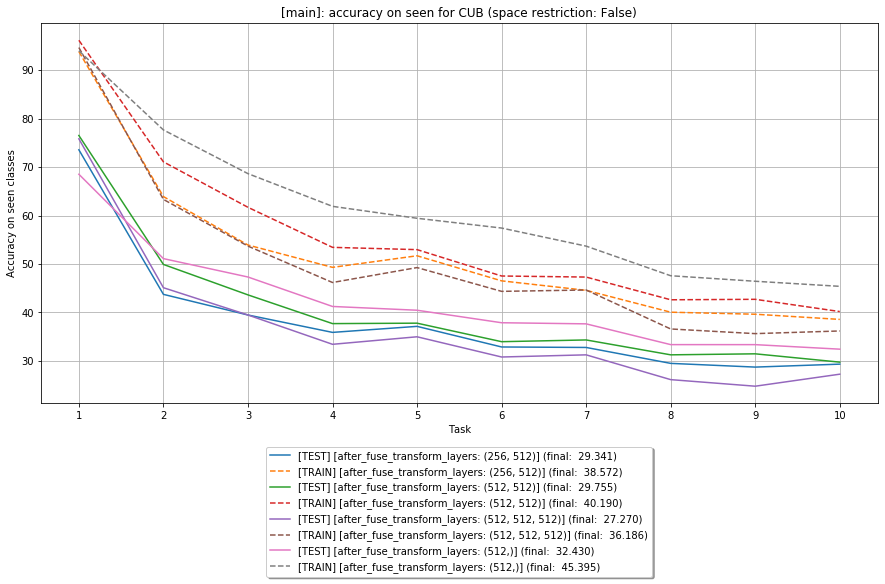

In [45]:
groups = {"main": {}}

baseline_group = {'hp.head.num_prototypes': 1}

for title, group in tqdm(groups.items()):
    methods = get_exps_for_a_group(exps, configs, group)
    methods = {**get_exps_for_a_group(exps, configs, baseline_group), **methods}
    
    plot_unseen_acc(methods, title=title)
    plot_seen_acc(methods, title=title)